<a id="index"></a>
# N-GRAM SENTIMENT ANALYSIS

------------------------------------------------------------------

**[1. Load Data & Libraries](#load)**
<br>
**[2. Word Vectors](#wvec)**
<br> &nbsp;&nbsp;&nbsp; - [Features weighted by Inverse-Document Frequency (TF-Idf)](#tvec)
<br> &nbsp;&nbsp;&nbsp; - [Features weighted by Frequency (Count-Vec)](#cvec)
<br> &nbsp;&nbsp;&nbsp; - [Best Results](#best)
<br>
**[3. Sentiment Analysis - All Features](#all)**
<br> &nbsp;&nbsp;&nbsp; - [Baseline Performances](#baseline)
<br> &nbsp;&nbsp;&nbsp; - [Comparison to Logistic Regression](#logistic)
<br> &nbsp;&nbsp;&nbsp; - [XGBoost Gridsearch](#grid)
<br> &nbsp;&nbsp;&nbsp; - [Decrease Overfitting](#adjust)
<br>
**[4. Word Embeddings - Features weighted by Semantic Distance](#embedding)**
<br> &nbsp;&nbsp;&nbsp; - [Next Steps...](#next)

--------------------------------------------------------------
<a id="load"></a>
# Load Data & Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from libraries_bert import *

np.random.seed(0)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load train, val, test sets
X_train = pd.read_json('data/train.json', orient='columns')
X_val = pd.read_json('data/val.json', orient='columns')
X_test = pd.read_json('data/test.json', orient='columns')
X = pd.read_json('english_reviews_processed.json', orient='columns')

y_train = X_train.sentiment.to_numpy().flatten()
y_val = X_val.sentiment.to_numpy().flatten()
y_test = X_test.sentiment.to_numpy().flatten()

# Remove validation and test data from full English text corpus
X = X[~X.review_id.isin(X_val.review_id.tolist() + X_test.review_id.tolist())]

len(X_train), len(X_val), len(X_test), len(X)

(143095, 11130, 4770, 594524)

In [4]:
X_train.head()

,review_id,category_pos,category_pos_names,category_neg,category_neg_names,pos_count,neg_count,sentiment,positive,negative,...,char_count,aws_preds,aws_numeric_sent,vadar_compound,vadar_pos,vadar_neg,vadar_neu,tb_sentiment,weights,corrected_label
95213,807221,"[349, 343, 313, 355]","Manager, Service, Food, Atmosphere",,None,4,0,1,1,0,...,121,1,1,0.9393,0.477,0.0,0.523,0.6700,0.077,pos
127356,1106328,"[313, 343, 361, 355]","Food, Service, Facilities, Atmosphere",,None,4,0,1,1,0,...,48,1,1,0.8442,0.603,0.0,0.397,0.6000,0.077,pos
12130,157099,[679],Food,,None,1,0,1,1,0,...,24,1,1,0.8481,0.804,0.0,0.196,0.8000,0.077,pos
20350,178675,"[501, 527]","Food, Service",,None,2,0,1,1,0,...,25,1,1,0.6249,0.577,0.0,0.423,0.8000,0.077,pos
143333,1370465,"[679, 705]","Food, Service","[715, 711]","Waiting Times, Service",2,2,2,1,1,...,103,0,1,0.8832,0.424,0.0,0.576,0.4725,1.000,pos


<a id="wvec"></a>
# Word Vectors
[Return to Index](#index)

Features for language modeling/ text classification are often created by mapping words or phrases to vectors of real numbers. The values of the vectors depend on the method used to weight the word/phrase. Three different methods are used in this notebook for predicting sentiment: '`TF-IDF` (tvec), `count vectorization` (cvec) and `word embeddings`.   

`Logistic Regression` and `XGBoost` classifiers will be used to benchmark the tvec and cvec ngrams. 

In [6]:
def compare_ngrams(train, y_train, val, y_val, wvec_name, wvec,
                   plot_cm = False, weights=None):
    
    df = pd.DataFrame()
    
    wvec_pipe = Pipeline([
                    (wvec_name, wvec),
                    ('svd', 'passthrough')])
                         
    pipeline = Pipeline([
                ('ngrams', wvec_pipe),
                ('clf', LogisticRegression(multi_class='multinomial', 
                                           class_weight='balanced',
                                           solver = 'newton-cg'))])
        
    # list of dicts for parameters - one for each classfier + ngrams + nfeatures
    parameters = [
        {'clf': [LogisticRegression(multi_class='multinomial', 
                                    class_weight='balanced',
                                    solver = 'newton-cg')],
         'ngrams__' + wvec_name + '__max_features': np.arange(10000,100001,10000),
         'ngrams__' + wvec_name + '__ngram_range': [(1, 2), (1,3),(1,4)]},
        
        {'clf': [XGBClassifier(objective='multi:softprob', num_class=3)],
         'ngrams__' + wvec_name + '__max_features': np.arange(10000,100001,10000),
         'ngrams__' + wvec_name + '__ngram_range': [(1, 2), (1,3), (1,4)],
         'ngrams__svd': [TruncatedSVD(algorithm='randomized', random_state=42, 
                                      n_components=300)]}
        ]
    
    # multiprocessing requires the fork to happen in a __main__ protected
    # block
    if __name__ == "__main__":
    
        scoring = {'f1': 'f1_macro'}

        gs = GridSearchCV(pipeline, parameters, cv=2, n_jobs=-1, verbose=2,
                          scoring=scoring, refit='f1')
        
        gs.fit(train, y_train, clf__sample_weight=weights)

        results = pd.DataFrame(gs.cv_results_)
        if plot_cm:
            plot_cm_best_estimator(gs, val, y_val, ['neg', 'pos', 'mixed'])
        
    return results, gs

<a id="tvec"></a>
## Features weighted by Inverse-Document Frequency (TF-IDF)

`TF-IDF` (term frequency-inverse document frequency) is a statistical measure that evaluates _how relevant a word is to a document in a collection of documents_. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 73.5min finished


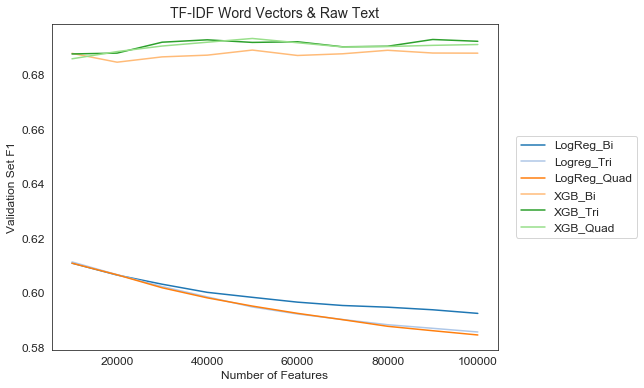

In [8]:
tvec = TfidfVectorizer()
wvec_name = 'tfidf'

results_tfidf_raw, gs_tfidf_raw = compare_ngrams(X_train['combined'], y_train, 
                                                 X_val['combined'], y_val,
                                                 wvec_name=wvec_name, wvec=tvec, 
                                                 weights=X_train['weights'])

tfidf_raw = plot_ngrams(results_tfidf_raw, title='TF-IDF Word Vectors & Raw Text', 
                        wvec_name=wvec_name)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 20.0min finished


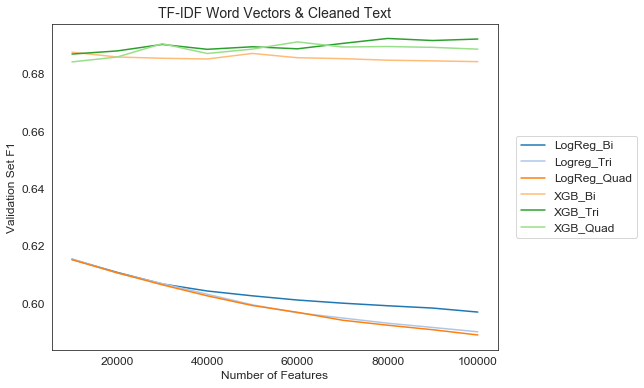

In [213]:
tvec = TfidfVectorizer()
wvec_name = 'tfidf'

results_tfidf_clean, gs_tfidf_clean = compare_ngrams(X_train['clean_text'], y_train, 
                                                     X_val['clean_text'], y_val,
                                                     wvec_name=wvec_name, wvec=tvec, 
                                                     weights=X_train['weights'])

tfidf_clean = plot_ngrams(results_tfidf_clean, title='TF-IDF Word Vectors & Cleaned Text', 
                          wvec_name=wvec_name)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 22.5min finished


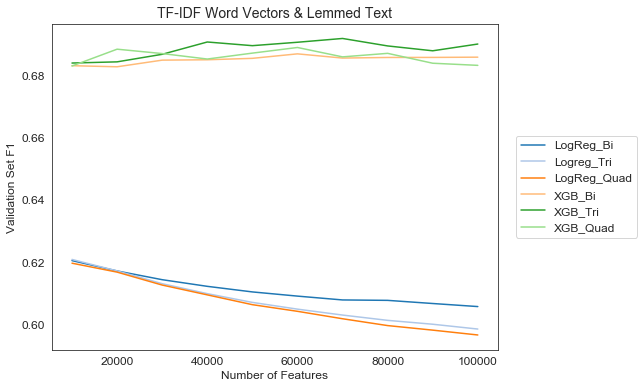

In [215]:
def identity_tokenizer(text):
    return text

tvec = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
wvec_name = 'tfidf'

results_tfidf_lem, gs_lem = compare_ngrams(X_train['lemmed_tokens'], y_train, 
                                           X_val['lemmed_tokens'], y_val,
                                           wvec_name=wvec_name, wvec=tvec, 
                                           weights=X_train['weights'])

tfidf_lemmed = plot_ngrams(results_tfidf_lem, title='TF-IDF Word Vectors & Lemmed Text',
                           wvec_name=wvec_name)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 18.0min finished


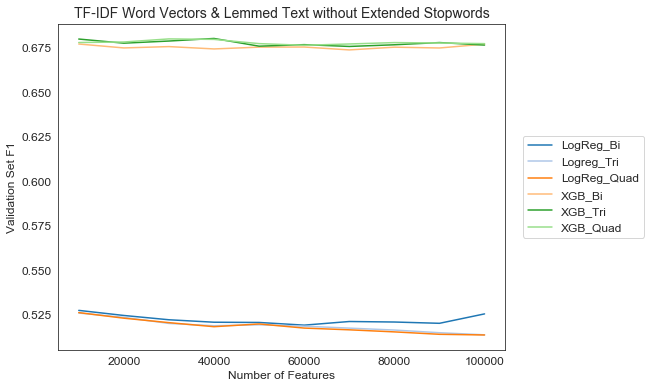

In [216]:
tvec = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
wvec_name = 'tfidf'

results_tfidf_wesw, gs_wesw = compare_ngrams(X_train['tokens_wesw'], y_train, 
                                             X_val['tokens_wesw'], y_val,
                                             wvec_name=wvec_name, wvec=tvec, 
                                             weights=X_train['weights'])

tfidf_wesw = plot_ngrams(results_tfidf_wesw, 
                         title='TF-IDF Word Vectors & Lemmed Text without Extended Stopwords',
                         wvec_name=wvec_name)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 16.8min finished


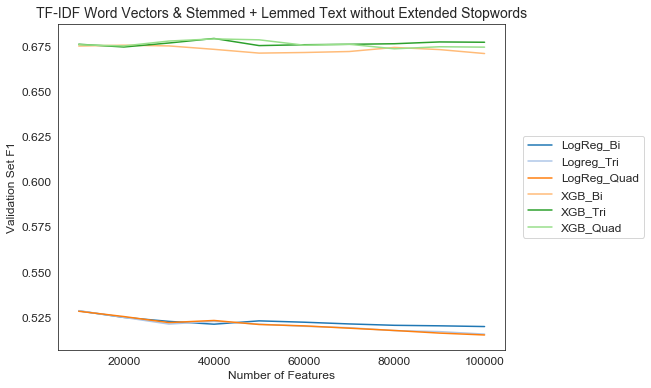

In [217]:
tvec = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
wvec_name = 'tfidf'

results_tfidf_stem_wesw, gs_stem_wesw = compare_ngrams(X_train['tokens_wesw_stem'], y_train, 
                                                       X_val['tokens_wesw_stem'], y_val,
                                                       wvec_name=wvec_name, wvec=tvec, 
                                                       weights=X_train['weights'])

tfidf_stem_wesw = plot_ngrams(results_tfidf_stem_wesw, 
                              title='TF-IDF Word Vectors & Stemmed + Lemmed Text without Extended Stopwords',
                              wvec_name=wvec_name)

------------------------------------------------
<a id="cvec"></a>
## Features weighted by Frequency (Count-Vec)

This is the bag of words model, where we are only concerned with encoding schemes that represent what words are present or the degree to which they are present in encoded documents without any information about order.

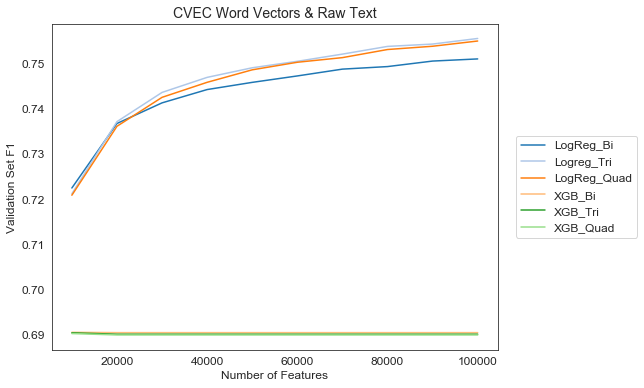

In [208]:
cvec = CountVectorizer()
wvec_name = 'cvec'

results_cvec_raw, gs_cvec_raw = compare_ngrams(X_train['combined'], y_train, 
                                            X_val['combined'], y_val,
                                            wvec_name=wvec_name, wvec=cvec, 
                                            weights=X_train['weights'])

cvev_raw = plot_ngrams(results_cvec_raw, title='CVEC Word Vectors & Raw Text', 
                       wvec_name=wvec_name)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 23.8min finished


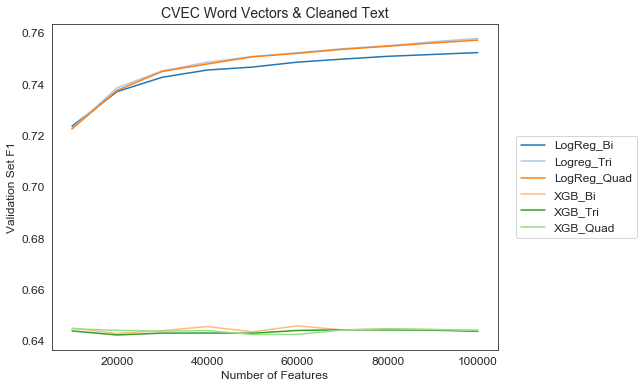

In [218]:
cvec = CountVectorizer()
wvec_name = 'cvec'

results_cvec_clean, gs_cvec_clean = compare_ngrams(X_train['clean_text'], y_train, 
                                                   X_val['clean_text'], y_val,
                                                   wvec_name=wvec_name, wvec=cvec, 
                                                   weights=X_train['weights'])

cvev_clean = plot_ngrams(results_cvec_clean, title='CVEC Word Vectors & Cleaned Text', 
                         wvec_name=wvec_name)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 25.7min finished


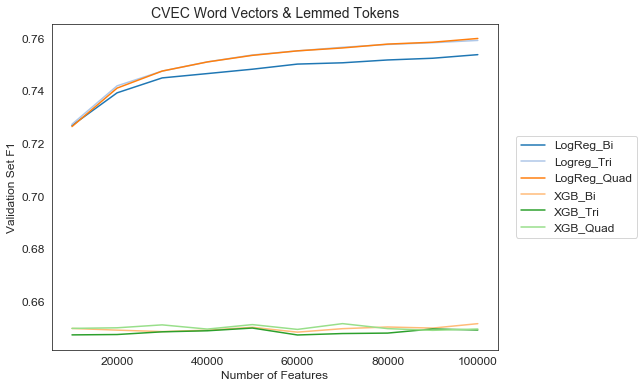

In [219]:
cvec = CountVectorizer(tokenizer=identity_tokenizer, lowercase=False)
wvec_name = 'cvec'

results_cvec_lem, gs_cvec_lem = compare_ngrams(X_train['lemmed_tokens'], y_train, 
                                               X_val['lemmed_tokens'], y_val,
                                               wvec_name=wvec_name, wvec=cvec, 
                                               weights=X_train['weights'])

cvev_lem = plot_ngrams(results_cvec_lem, title='CVEC Word Vectors & Lemmed Tokens', 
                       wvec_name=wvec_name)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 20.0min finished


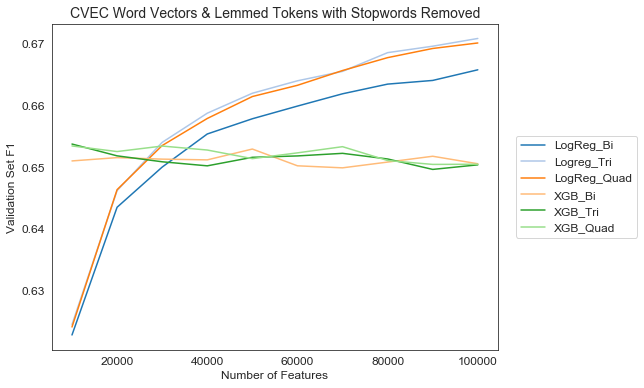

In [220]:
cvec = CountVectorizer(tokenizer=identity_tokenizer, lowercase=False)
wvec_name = 'cvec'

results_cvec_wesw, gs_cvec_wesw = compare_ngrams(X_train['tokens_wesw'], y_train, 
                                                 X_val['tokens_wesw'], y_val,
                                                 wvec_name=wvec_name, wvec=cvec, 
                                                 weights=X_train['weights'])

cvev_wesw = plot_ngrams(results_cvec_wesw, title='CVEC Word Vectors & Lemmed Tokens with Stopwords Removed', 
                        wvec_name=wvec_name)

------------------------------------------------------------
<a id="best"></a>
## Best Results

The `XGBoost TF-IDF Trigrams` appeared to result in the best `macro-weighted F1-score`. Class-weighted XGBoost also previously resulted in the best balanced predictions using sentiment and text features as input ([features_benchmarking_eda.ipynb](features_benchmarking_eda.ipynb)). Therefore, XGBoost will be used with all features as inputs and fine-tuned. 

In [227]:
parse_results(results_tfidf_clean, 'tfidf')

,nfeatures,LogReg_Bi,Logreg_Tri,LogReg_Quad,XGB_Bi,XGB_Tri,XGB_Quad
0,10000,0.615333,0.615497,0.615198,0.687539,0.686883,0.684145
1,20000,0.610786,0.610586,0.610645,0.685859,0.687968,0.685839
2,30000,0.606760,0.606873,0.606456,0.685412,0.690236,0.690493
3,40000,0.604283,0.603159,0.602599,0.685165,0.688540,0.687077
4,50000,0.602605,0.599468,0.599225,0.687102,0.689424,0.688621
5,60000,0.601136,0.596684,0.596856,0.685603,0.688712,0.691119
6,70000,0.600045,0.594875,0.594095,0.685283,0.690592,0.689340
7,80000,0.599143,0.593060,0.592361,0.684741,0.692318,0.689510
8,90000,0.598333,0.591572,0.590786,0.684500,0.691604,0.689225
9,100000,0.596938,0.590061,0.588955,0.684239,0.692124,0.688583


In [230]:
parse_results(results_cvec_clean, 'cvec')

,nfeatures,LogReg_Bi,Logreg_Tri,LogReg_Quad,XGB_Bi,XGB_Tri,XGB_Quad
0,10000,0.723564,0.722730,0.722506,0.644976,0.643848,0.644689
1,20000,0.737033,0.738497,0.737511,0.642872,0.642270,0.644080
2,30000,0.742602,0.745082,0.744860,0.643955,0.642997,0.643773
3,40000,0.745430,0.748463,0.747775,0.645551,0.643030,0.643981
4,50000,0.746578,0.750673,0.750564,0.643485,0.642936,0.642468
5,60000,0.748503,0.752182,0.751930,0.645811,0.644028,0.642483
6,70000,0.749684,0.753728,0.753488,0.644247,0.644280,0.644193
7,80000,0.750767,0.754900,0.754678,0.644737,0.644226,0.644638
8,90000,0.751489,0.756436,0.755948,0.644353,0.644152,0.644420
9,100000,0.752228,0.757717,0.757074,0.644189,0.643676,0.643987


<a id="all"></a>
# Sentiment Analysis - All Features
[Return to Index](#index)

<a id="baseline"></a>
## Baseline Performances

Get baseline performance with all features prior to fine-tuning.

Macro F1 score:  0.7835580712508939
Normalized confusion matrix
Wall time: 17min 46s


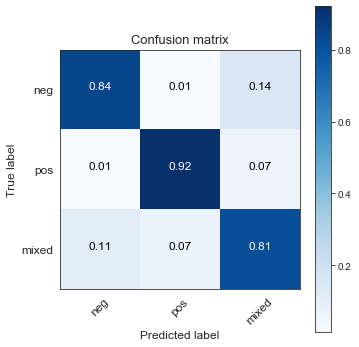

In [60]:
%%time
# preprocess train & validation sets
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key]
    
tfidf_pipe = Pipeline([
    ('text', ItemSelector(key='clean_text')),
    ('tfidf', TfidfVectorizer(max_features=80000, ngram_range=(1,3))),
    # transform sparse matrix to dense for RandomizedSearchCV.
    ('svd', TruncatedSVD(algorithm='randomized', random_state=42, n_components=300))
])

features_pipe = Pipeline([
    ('select', ItemSelector(key=['rating', 'aws_neg', 'aws_pos', 'aws_mix', 'char_count',
                                 'vadar_pos', 'vadar_neg', 'vadar_neu', 'tb_sentiment']))])

feature_union_pipe = FeatureUnion([   
    ('tfidf', tfidf_pipe),
    ('features', features_pipe)
])

xgb_pipe = Pipeline([
    ('all_features', feature_union_pipe),
    ('xgb', XGBClassifier(objective='multi:softprob', num_class=3))
])

xgb = xgb_pipe.fit(X_train, y_train, xgb__sample_weight=X_train['weights'])
probs = xgb.predict_proba(X_val)
preds = xgb.predict(X_val)

print('Macro F1 score: ', f1_score(y_val, preds, average='macro'))
cm = confusion_matrix(y_val, preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'])

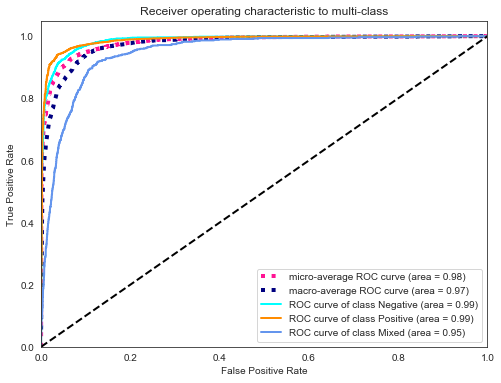

In [62]:
multiclass_roc_curve(probs, y_val)

<a id="logistic"></a>
## Comparison to Logistic Regression

Just for comparison, to ensure no surprise improvements when all features are added together. 

Macro F1 score:  0.7992631412718163
Normalized confusion matrix


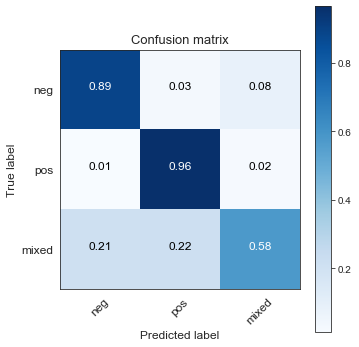

In [30]:
# Despite a higher F1 score, the classifier does a poor job of 
# balancing the classes and predicting the minority class.  
cvec_pipe = Pipeline([
    ('text', ItemSelector(key='clean_text')),
    ('cvec', CountVectorizer(max_features=100000, ngram_range=(1,3)))
])

feature_union_pipe = FeatureUnion([   
    ('cvec', cvec_pipe),
    ('features', features_pipe)
])

logreg_pipe = Pipeline([
    ('all_features', feature_union_pipe),
    ('logreg', LogisticRegression(multi_class='multinomial', 
                                  class_weight='balanced',
                                  solver = 'newton-cg'))])

clf = logreg_pipe.fit(X_train, y_train)
probs_lg = clf.predict_proba(X_val)
preds_lg = clf.predict(X_val)

print('Macro F1 score: ', f1_score(y_val, preds_lg, average='macro'))
cm = confusion_matrix(y_val, preds_lg)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'])

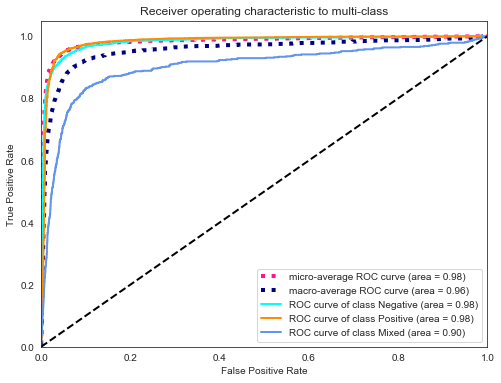

In [59]:
multiclass_roc_curve(probs_lg, y_val)

<a id="grid"></a>
## XGBoost Gridsearch

In [34]:
train_tfidf = feature_union_pipe.fit_transform(X_train)
val_tfidf = feature_union_pipe.transform(X_val)
test_tfidf = feature_union_pipe.transform(X_test)

train_tfidf.shape, y_train.shape, val_tfidf.shape, y_val.shape, test_tfidf.shape

((143095, 309), (11130, 309), (4770, 309))

Randomized search..
Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 84.7min remaining: 28.2min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 110.7min finished


Randomized search time:
Best score: 0.812516406648556
Best params: 
gamma: 0.5
learning_rate: 0.2
min_child_weight: 5.0
n_estimators: 500
reg_lambda: 1.0
silent: False
subsample: 0.5
Macro F1 score:  0.807549513048566
Normalized confusion matrix
Wall time: 2h 52min 12s


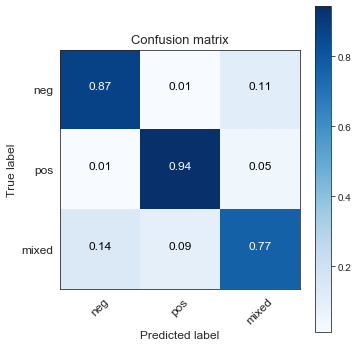

In [47]:
%%time
#rs_clf.get_params().keys()
#sklearn.metrics.SCORERS.keys()

param_grid = {
        'silent': [False],
        'subsample': [0.5],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0.0, 0.25, 0.5, 1.0],
        'reg_lambda': [1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100, 250, 500]}  
        
fit_params = {'sample_weight': X_train['weights'],
              'verbose': False}

if __name__ == "__main__":
    
    scoring = {'f1': 'f1_macro', 'logloss': 'neg_log_loss'}
    
    rs_clf = RandomizedSearchCV(model, param_grid, n_iter=20,
                                n_jobs=-1, verbose=2, cv=2,
                                scoring=scoring, 
                                refit='f1', 
                                random_state=42)

    print("Randomized search..")
    rs_clf.fit(train_tfidf, y_train, **fit_params)
    print("Randomized search time:")

    best_score = rs_clf.best_score_
    best_params = rs_clf.best_params_
    print("Best score: {}".format(best_score))
    print("Best params: ")
    for param_name in sorted(best_params.keys()):
        print('%s: %r' % (param_name, best_params[param_name]))
        
rs_probs = rs_clf.predict_proba(val_tfidf)
rs_preds = np.argmax(rs_probs, axis=1)

print('Macro F1 score: ', f1_score(y_val, rs_preds, average='macro'))
cm = confusion_matrix(y_val, rs_preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'])

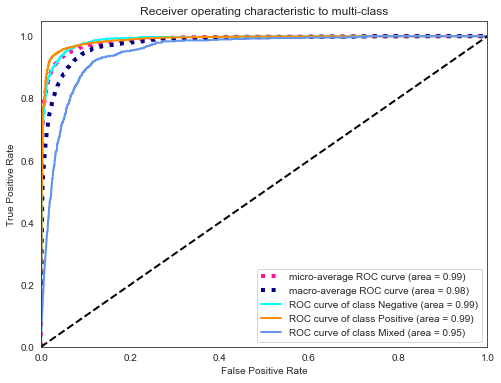

In [56]:
multiclass_roc_curve(rs_probs, y_val)

<a id="adjust"></a>
## Decrease Overfitting

The gridsearch tends to overfit since predicting the majority classes results in better optimization (minimizes loss and maximizes F1, despite the macro averaging). 

If we regularize the model a bit more by restricting `max_depth` and adjusting `colsample_bylevel` and `bytree` we see that the predictions shift in favor of the minority class slightly.

Macro F1 score:  0.8013320500244531
Normalized confusion matrix


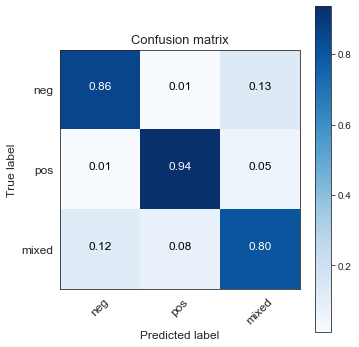

In [48]:
xgb = XGBClassifier(objective='multi:softprob', 
                    num_class=3,
                    learning_rate=0.1,
                    max_depth=3,
                    n_estimators=500,
                    min_child_weight=5.0,
                    colsample_bylevel=0.7,
                    colsample_bytree=0.5)

xgb.fit(train_tfidf, y_train, sample_weight=X_train['weights'])
probs = xgb.predict_proba(val_tfidf)
preds = xgb.predict(val_tfidf)

print('Macro F1 score: ', f1_score(y_val, preds, average='macro'))
cm = confusion_matrix(y_val, preds)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'])

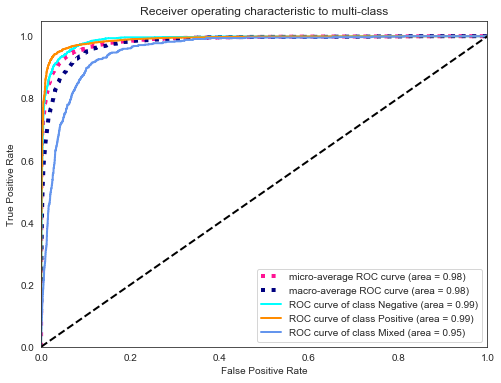

In [57]:
multiclass_roc_curve(probs, y_val)

<a id="embedding"></a>
# Word Embeddings - Features weighted by Semantic Distance
[Return to Index](#index)

In [9]:
# train word2vec model with lemmed text
lemmed_text = X.lemmed_tokens
w2v_lem = Word2Vec(lemmed_text, size=50, window=5, min_count=3, workers=4)
w2v_lem.train(lemmed_text, total_examples=w2v_lem.corpus_count, epochs=15)
wv_lem = w2v_lem.wv
wv_lem.most_similar('bad')

[('terrible', 0.8477630615234375),
 ('poor', 0.8123553991317749),
 ('horrible', 0.7971954345703125),
 ('shock', 0.7615512609481812),
 ('dreadful', 0.7536356449127197),
 ('awful', 0.7524489164352417),
 ('dissapointing', 0.7402597665786743),
 ('horrific', 0.7391804456710815),
 ('dismal', 0.7238195538520813),
 ('crap', 0.7200228571891785)]

In [12]:
# train word2vec model with lemmed text
text_wsw = X.tokens_wsw
w2v_wsw = Word2Vec(text_wsw, size=50, window=5, min_count=3, workers=4)
w2v_wsw.train(text_wsw, total_examples=w2v_wsw.corpus_count, epochs=15)
wv_wsw = w2v_wsw.wv
wv_wsw.most_similar('bad')

[('terrible', 0.921938419342041),
 ('horrible', 0.8812323808670044),
 ('poor', 0.8629473447799683),
 ('worst', 0.8415224552154541),
 ('awful', 0.8202757239341736),
 ('worse', 0.8185065984725952),
 ('horrific', 0.802024245262146),
 ('miserable', 0.7921717166900635),
 ('shock', 0.7875691056251526),
 ('dreadful', 0.7805178165435791)]

In [11]:
# train word2vec model with lemmed text and extended stopwords removed
text_wesw = X.tokens_wesw
w2v_wesw = Word2Vec(text_wesw, size=50, window=5, min_count=3, workers=4)
w2v_wesw.train(text_wesw, total_examples=w2v_wesw.corpus_count, epochs=15)
wv_wesw = w2v_wesw.wv
wv_wesw.most_similar('bad')

[('terrible', 0.9105643630027771),
 ('horrible', 0.8696433305740356),
 ('poor', 0.8458884954452515),
 ('worst', 0.8392006158828735),
 ('worse', 0.8376070261001587),
 ('awful', 0.8139978647232056),
 ('pathetic', 0.7843503355979919),
 ('crappy', 0.7799187898635864),
 ('shock', 0.7713626623153687),
 ('dreadful', 0.7701734900474548)]

In [14]:
# The lemmed text with shorter stopwords list resulted in the best 
# word vector similarity scores, indicating that using this level of text-
# preprocessing works best. 

filename = 'w2v_embeddings.txt'
wv_wsw.save_word2vec_format(filename, binary=False)

# Get average embeddings per review
embeddings_index = {}
with open(os.path.join('', 'w2v_embeddings.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings_index[word] = coefs

model = gensim.models.KeyedVectors.load_word2vec_format('w2v_embeddings.txt', binary=False)

train_text = X_train[['review_id','%clearens_wsw']]
val_text = X_val[['review_id','tokens_wsw']]

def get_mean_vector(word2vec_model, texts):
    """ Return an average word vector for each review. """
    x = []
    removed = []
    for col, review in texts.iterrows():
        review_id = review.review_id
        text = review.tokens_wsw
        # remove out-of-vocabulary words
        words = [word for word in text if word in word2vec_model.vocab]
        if len(words) >= 1:
            vec = np.mean(word2vec_model[words], axis=0)
            x.append(vec)
        else:
            removed.append(review_id)
    X = np.array(x)
    return X, removed

train_vec, train_removed = get_mean_vector(model, train_text)
val_vec, val_removed = get_mean_vector(model, val_text)

X_val = X_val[~X_val.review_id.isin(val_removed)]
X_train = X_train[~X_train.review_id.isin(train_removed)]
y_val = X_val.sentiment[~X_val.review_id.isin(val_removed)]
y_train = X_train.sentiment[~X_train.review_id.isin(train_removed)]

len(y_train), train_vec.shape, len(y_val), val_vec.shape, 

(142848, (142848, 50), 11111, (11111, 50))

In [25]:
features = ['rating', 'aws_neg', 'aws_pos', 'aws_mix', 'char_count',
            'vadar_pos', 'vadar_neg', 'vadar_neu', 'tb_sentiment']

train = np.hstack([train_vec, X_train[features].to_numpy()])
val = np.hstack([val_vec, X_val[features].to_numpy()])

train.shape, val.shape

((142848, 59), (11111, 59))

Normalized confusion matrix
Wall time: 2min 48s


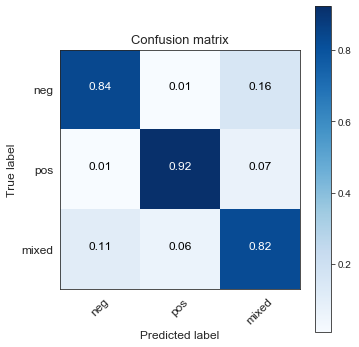

In [26]:
%%time

xgb = XGBClassifier(objective='multi:softprob', num_class=3)
xgb.fit(train, y_train, sample_weight=X_train['weights'].values)

y_pred = xgb.predict(val)

cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm, ['neg', 'pos', 'mixed'], normalize=True)

---------------------------
Using the semantic word vectors with the other input features resulted in similar performance to XGBoost TF-IDF Trigrams with all features.

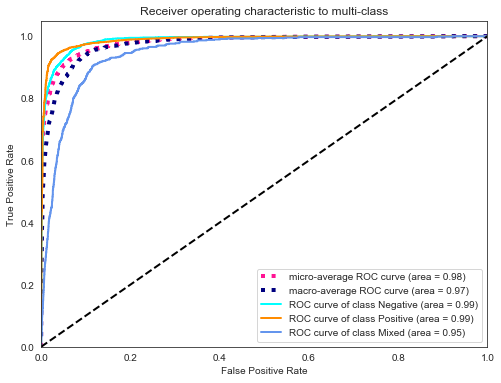

In [28]:
probs = xgb.predict_proba(val)
multiclass_roc_curve(probs, y_val.values)

<a id="next"></a>
## Next Steps...
The end-to-end bert learning model outperforms the current xgboost models (and simplifies the overall pipeline by taking raw text and excluding the need for feature engineering and text preprocessing). If that solution hadn't worked, or been viable for some reason, the next steps would have been to combined word vectors as multiple inputs to an LSTM neural network, or even possibly a CNN. Perhaps even combined inputs with xgboost.

[Return to Index](#index)